In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

from desc import set_device
set_device("gpu")

In [3]:
import numpy as np

np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
import warnings
import plotly.graph_objects as go
from diffrax import (
    Tsit5,
    SaveAt,
    PIDController,
)

import desc
from desc.particles import (
    trace_particles,
    _trace_particles,
    VacuumGuidingCenterTrajectory,
    ManualParticleInitializerFlux,
    ManualParticleInitializerLab,
    SurfaceParticleInitializer,
    CurveParticleInitializer,
)
from desc.backend import vmap, print_backend_info, jnp
from desc.examples import get
from desc.grid import LinearGrid, Grid

from desc.plotting import (
    plot_3d,
    plot_field_lines,
    plot_particle_trajectories,
)

print_backend_info()

DESC version=0.14.2+721.ge41fabe82.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 11.57 GB available memory.


# Particle Tracing in DESC

Here we will try to show different functionality to trace particles, plot results and to see the differentiable version of the particle tracer in DESC.This notebook might not cover the whole functionality, but further questions are welcomed thorugh Slack or Github.

## Some quick results

Before using the underlying function, let's use some of the plotting functions to see what  trajectories look like.

`NCSX` equilibrium as example with 1 particle to trace. We will use vacuum guiding center trajectory model in flux coordinates for 3e-4 seconds.

In [3]:
eq = get("NCSX")
model = VacuumGuidingCenterTrajectory(frame="flux")
particles = ManualParticleInitializerFlux(
    rho0=0.4,
    theta0=0,
    zeta0=0,
    xi0=0.3,
    E=1e4, 
    m=4,
    q=2,
)
ts = np.linspace(0, 3e-4, 1000)

With only these inputs, we can ready to trace particles in DESC! Let's plot both the trajectory and the LCFS of the equilibrium.

In [4]:
# 3D plots use grid NFP=1 to plot all toroidal surfaces
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig = plot_3d(eq, "|B|", alpha=0.3)
fig, data = plot_particle_trajectories(
    eq,
    model,
    particles,
    ts=ts,
    fig=fig,
    return_data=True,
)
fig

We can also use the output data to plot custom figures like particle $\rho$ vs time, top view trajectory etc.

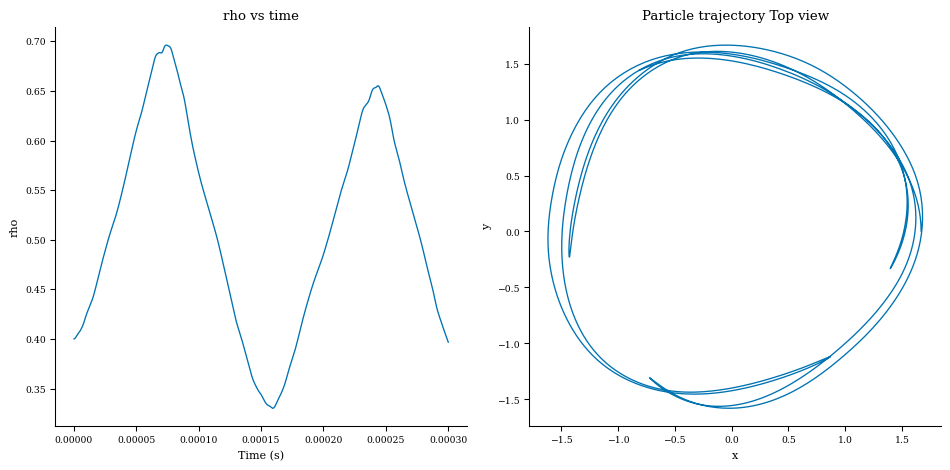

In [5]:
rho = data["rho"][0]
theta = data["theta"][0]
phi = data["phi"][0]
X = data["X"][0]
Y = data["Y"][0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(ts, rho)
ax[0].set_title("rho vs time")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("rho")
ax[1].plot(X, Y)
ax[1].set_title("Particle trajectory Top view")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y");

Some bananas 🍌!

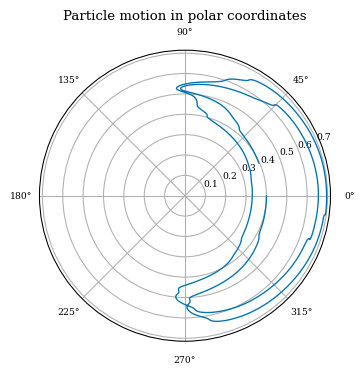

In [6]:
plt.polar(theta, rho);
plt.title("Particle motion in polar coordinates");

## Particle Tracing using a MagneticField Class

Everything is basically the same, but we just need to use lab coordinates $(R, \phi, Z)$. We will use an example coil field used for DESC testing, the field might night have perfect $\mathbf{B}\cdot\hat{n}$.

In [7]:
eq = get("precise_QA")
field = desc.io.load("../../../tests/inputs/precise_QA_helical_coils.h5")
model = VacuumGuidingCenterTrajectory(frame="lab")
particles = ManualParticleInitializerLab(
    R0=1.2,
    phi0=0,
    Z0=0,
    xi0=0.3,
    E=1e4,
    m=4,
    q=2,
)
ts = np.linspace(0, 3e-5, 1000)

For fun, let's also plot the field line correspoinding to the initial position! Black line for particle trajectory and red one is for field line.

In [8]:
# 3D plots use grid NFP=1 to plot all toroidal surfaces
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig = plot_3d(eq, "|B|", alpha=0.3)
fig = plot_particle_trajectories(
    field,
    model,
    particles,
    ts=ts,
    fig=fig,
)
plot_field_lines(
    field,
    R0=1.2,
    Z0=0,
    ntransit= 1.2,
    nphi_per_transit=300,
    color="red",
    lw=10,
    fig=fig,
)

## Particle Initializers

- Current possible options are:
    - `ManualParticleInitializerLab()` 
    - `ManualParticleInitializerFlux()` 
    - `SurfaceParticleInitializer()`
    - `CurveParticleInitializer()`


We have seen the first 2, let's see the others!

### `SurfaceParticleInitializer()`

Initializes N number of random particles on a given surface with probability based on $|e_\theta\times e_\zeta|$.

In [9]:
eq = get("ESTELL")

rho = 0.4
# Get the rho=0.4 surface of the ESTELL
surf = eq.get_surface_at(rho=rho)
# This grid specifies the possible particle birth positions
surf_grid = LinearGrid(rho=rho, M=10, N=40, NFP=1)
model = VacuumGuidingCenterTrajectory(frame="flux")
particles_surf = SurfaceParticleInitializer(surface=surf, N=100, grid=surf_grid)

We need to do some preprocessing to plot initial positions, we don't have a utility function for this yet. 

We will first initialize particles in flux corrdinates, and get the real space coordinates of those (since plotting is done on real space).

In [10]:
# All particle initializers have init_particles methods
# that give the initial position, velocity and arguments needed for
# trajectory model, such as mass, charge and magnetic moment
x0, args = particles_surf.init_particles(model, eq)

# convert flux to lab
def to_lab(coords):
    grid = Grid(coords, jitable=True)
    return eq.compute("x", grid=grid)["x"]

rpz = vmap(to_lab, in_axes=(0,))(x0[:, :3])
xs = rpz[:, 0, 0] * jnp.cos(rpz[:, 0, 1])
ys = rpz[:, 0, 0] * jnp.sin(rpz[:, 0, 1])
zs = rpz[:, 0, 2]

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.



In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig = plot_3d(
        surf,
        "|e_theta x e_zeta|",
        cmap="plasma",
        showscale=False,
    )
    fig = plot_3d(
        eq,
        "|e_theta x e_zeta|",
        alpha=0.1,
        fig=fig,
        showscale=False,
        cmap="plasma",
    )
fig.add_trace(
    go.Scatter3d(
        x=xs,
        y=ys,
        z=zs,
        mode="markers",
        marker=dict(size=10, color="black"),
        showlegend=False,
    )
)

### `CurveParticleInitializer`

In [15]:
axis = eq.get_axis()
axis_grid = LinearGrid(N=40, rho=0)
particles_curve = CurveParticleInitializer(curve=axis, N=100, grid=axis_grid)
x0, args = particles_curve.init_particles(model, eq)

# Main Entry point `trace_particles`

All the above plotting functions hide the main entry point from the user. Let's now see the `trace_particles` and it's jit friendly version `_trace_particles`!

As usual, we need model, particles and field.

In [16]:
eqh = get("precise_QH")
model = VacuumGuidingCenterTrajectory(frame="flux")
particles = ManualParticleInitializerFlux(rho0=0.4, theta0=0, zeta0=0, xi0=0.5, E=1e4)
ts = np.linspace(0, 1e-4, 1000)
ts2save = ts[::3]

### Important Point!

Magnetic field calculation requires `iota` profile, and `precise_QH` has only current profile. This will make the $\mathbf{B}$ computation wrong! Normal DESC compute functions prevent this by having a larger grid, but for particle tracing we evaluate $\mathbf{B}$ on a point... The work around for that is to compute the `iota` profile before, and pass the `params` and the `iota` profile in `options`.

In [17]:
iota = eqh.get_profile("iota")
iota_params = iota.params

params = eqh.params_dict
params["i_l"] = iota_params

In [18]:
rtz, vs = trace_particles(
    field=eqh,
    initializer=particles,
    model=model,
    ts=ts,
    params=params,
    saveat=SaveAt(ts=ts2save),
    solver=Tsit5(),
    stepsize_controller=PIDController(atol=1e-8, rtol=1e-8),
    options={"iota": iota},
)

In [19]:
rho = rtz[0, :, 0]
theta = rtz[0, :, 1]
zeta = rtz[0, :, 2]

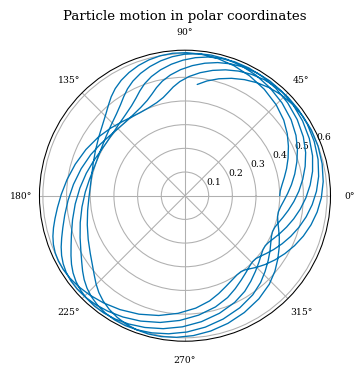

In [20]:
plt.polar(theta, rho)
plt.title("Particle motion in polar coordinates");

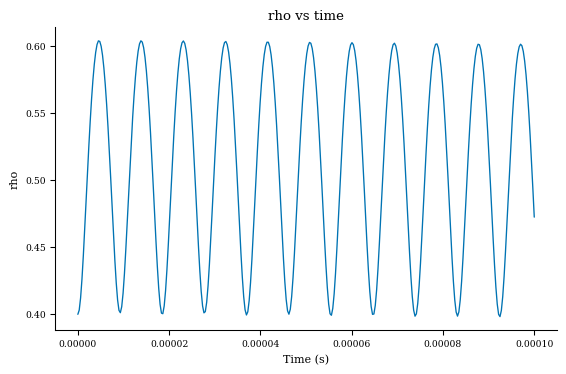

In [21]:
plt.plot(ts2save, rho)
plt.title("rho vs time")
plt.xlabel("Time (s)")
plt.ylabel("rho");

## Differentiable `_trace_particles`

Both `trace_particles` and `_trace_particles` take almost the inputs. The only difference is that `_trace_particles` takes the initialized particles.

In [22]:
x0, args = particles.init_particles(model, eqh)
rtz, vs = _trace_particles(
    field=eqh,
    y0=x0,
    model_args=args,
    model=model,
    ts=ts,
    params=params,
    saveat=SaveAt(ts=ts2save),
    solver=Tsit5(),
    stepsize_controller=PIDController(atol=1e-8, rtol=1e-8),
    options={"iota": iota},
)